In [1]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();
import libactive; reload(libactive)
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
cm = sns.color_palette('gist_ncar', 7, desat=0.4)

In [3]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("anuran", wrap(anuran, None)),
        #("avila", wrap(avila, None)),
        #("covertype", wrap(covertype, None)),
        #("rcv1", wrap(rcv1, None)),
        #("sensorless", wrap(sensorless, None)),
        ("spamassassin", wrap(spamassassin, None)),
        #("splice", wrap(splice, None)),
        #("swarm", wrap(swarm, None)),
        #("smartphone", wrap(smartphone, None))
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [4]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-471a57d0-d249-4165-9623-3f885bfd5bba.json']


Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

### List of stopping conditions & metrics to compute

In [46]:
reload(libstop); from libstop import *
def acc_wrapper(**kwargs):
    x, diffs = first_acc(**kwargs)
    return [np.nan] +diffs

stuff = {
    'GOAL': [partial(ZPS, order=2), acc_wrapper, None], 
    'SSNCut': [SSNCut, SSNCut_values, None], 
    'SC_entropy_mcs': [SC_entropy_mcs, 'entropy_max', 1e-2], 
    'SC_oracle_acc': [SC_oracle_acc_mcs, SC_oracle_acc_mcs_values, 0.9], 
    'SC_mes': [SC_mes, 'expected_error_min', 1e-2], 
    'Stabilizing Predictions': [stabilizing_predictions, kappa_metric, 0.99], 
    'Performance Convergence': [performance_convergence, fscore, None], 
    'Uncertainty Convergence': [uncertainty_convergence, partial(metric_selected, metric=classifier_entropy), None], 
    'Max Confidence': [max_confidence, partial(metric_selected, metric=classifier_entropy), 1e-3],
    'EVM': [EVM, 'uncertainty_variance_selected', None], 
    'VM': [VM, 'uncertainty_variance_selected', None], 
    'N support vectors': [None, 'n_support', None], 
    'Contradictory Information': [contradictory_information, 'contradictory_information', None], 
    'Kappa First': [None, kappa_metric_first, None],
    'Classification Change': [classification_change, classification_change_values, 1],
}

conditions = [x[0] for x in stuff.values()]
metric_values = [x[1] for x in stuff.values()]
thresholds = [x[2] for x in stuff.values()]
names = list(stuff.keys())

### Create the unlabelled pools

In [6]:
results = results_plots[0][1]
conf = results_plots[0][0]
X, y = getattr(libdatasets, conf.dataset_name)(None)
unlabelled_pools = []
y_oracles = []
# WARN: This is not the same as the job numbers! Unfortunately they're not easily accessible
for i in range(len(results)):
    _, X_unlabelled, _, Y_oracle, _, _ = active_split(
        X, y, labeled_size=conf.meta['labelled_size'], test_size=conf.meta['test_size'], random_state=check_random_state(i), ensure_y=conf.meta['ensure_y']
    )
    unlabelled_pools.append(X_unlabelled)
    y_oracles.append(Y_oracle)

### Evaluate the metrics

In [7]:
computed = {}

In [8]:
#del computed['Performance Convergence']

In [30]:
for metric, name in zip(metric_values, names):
    if name in computed:
        continue
    if isinstance(metric, str):
        values = np.array([results[i][metric] for i in range(len(results))])
    else:
        values = np.array([metric(**results[i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])

    computed[name] = values

In [10]:
computed['Performance Convergence'] = np.array([list(computed['Performance Convergence'][i]) for i in range(len(computed['Performance Convergence']))])
computed['Uncertainty Convergence'] = np.array([list(computed['Uncertainty Convergence'][i]) for i in range(len(computed['Uncertainty Convergence']))])
computed['Max Confidence'] = np.array([list(computed['Max Confidence'][i]) for i in range(len(computed['Max Confidence']))])

### Evaluate the conditions

In [11]:
computed_conds = {}

In [43]:
del computed_conds['Classification Change']

In [47]:
for cond, name in zip(conditions, names):
    if name in computed_conds:
        continue
    if cond is None:
        values = [None] * len(values)
    else:
        try:
            values = np.array([cond(**results[i], pre=computed[name][i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])
        except FailedToTerminate:
            values = [None] * len(results)
    computed_conds[name] = values

20
37


In [13]:
list(computed_conds.keys())

['GOAL',
 'SSNCut',
 'SC_entropy_mcs',
 'SC_oracle_acc',
 'SC_mes',
 'Stabilizing Predictions',
 'Performance Convergence',
 'Uncertainty Convergence',
 'Max Confidence',
 'EVM',
 'VM',
 'N support vectors',
 'Contradictory Information',
 'Kappa First']

### Create the plot

In [14]:
import seaborn as sns
cm = sns.color_palette('gist_ncar', 7, desat=0.4)

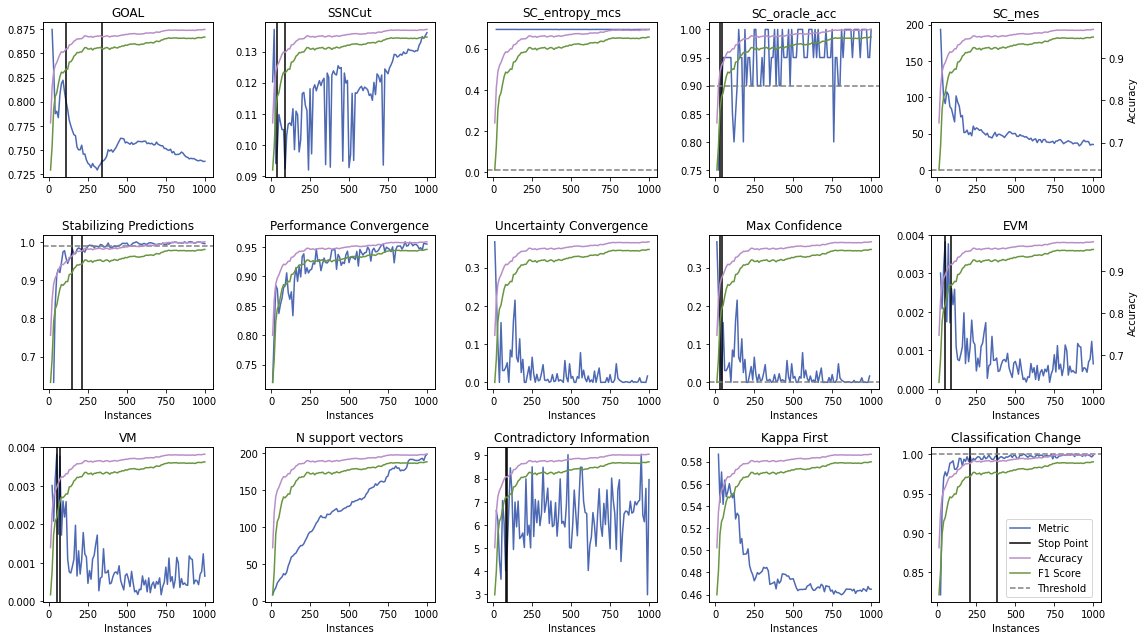

In [57]:
fig = plt.figure(figsize=(16,9))
plt.subplots_adjust(wspace=10, hspace=0.3)
from matplotlib.gridspec import GridSpec
gs = fig.add_gridspec(3,20)
threshold_legend = True
stop_legend = True
for j, (metric, name, threshold) in enumerate(zip(metric_values, names, thresholds)):
    x = j%5
    ax = fig.add_subplot(gs[j//5, x*4:(x+1)*4])
        
    values = computed[name]
        
    ax.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(values, axis=0), color=cm[0], label="Metric" if j == 0 else None)
    
    for stop in computed_conds[name]:
        if stop is None:
            continue
        ax.axvline(stop, color='black', label='Stop Point' if stop_legend else None)
        stop_legend = False
        
    if threshold is not None:
        ax.axhline(threshold, color='gray', ls='--', label='Threshold' if threshold_legend else None)
        threshold_legend = False
    
    ax2 = ax.twinx()
    ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), color=cm[6], label="Accuracy" if j == 0 else None)
    ax2.plot(results[0].x, np.mean(np.array([results[i]['f1_score'] for i in range(len(results))]), axis=0), color=cm[2], label="F1 Score" if j == 0 else None)

    ax2.set_ylabel('Accuracy')
    ax.set_title(name)
    
    if j != 4 and j != 9:
        ax2.axes.get_yaxis().set_visible(False)
    
    if j > 4:
        ax.set_xlabel("Instances")
       

fig.legend(bbox_to_anchor=(0.955, 0.2))
fig.tight_layout()

In [58]:
fig.savefig('figures/metrics_comparison_svm.png')

## Decision Trees

In [231]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("spamassassin", wrap(spamassassin, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "decision-tree"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-c9330753-7d4d-4d45-927f-679f011b92aa.json']


Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

In [232]:
reload(libstop); from libstop import *
def plot_with_metric(results_plots, classifiers):
    from matplotlib.gridspec import GridSpec

    stuff = {
        'GOAL': [partial(ZPS, order=2), acc_wrapper, None], 
        'SSNCut': [SSNCut, SSNCut_values, None], 
        'SC_entropy_mcs': [SC_entropy_mcs, 'entropy_max', 1e-2], 
        'SC_oracle_acc': [SC_oracle_acc_mcs, SC_oracle_acc_mcs_values, 0.9], 
        'SC_mes': [SC_mes, 'expected_error_min', 1e-2], 
        'Stabilizing Predictions': [stabilizing_predictions, kappa_metric, 0.99], 
        'Performance Convergence': [performance_convergence, fscore, None], 
        'Uncertainty Convergence': [uncertainty_convergence, partial(metric_selected, metric=classifier_entropy), None], 
        'Max Confidence': [max_confidence, partial(metric_selected, metric=classifier_entropy), 1e-3],
        'EVM': [EVM, 'uncertainty_variance_selected', None], 
        'VM': [VM, 'uncertainty_variance_selected', None], 
        'N support vectors': [None, 'n_support', None], 
        'Contradictory Information': [contradictory_information, 'contradictory_information', None], 
        'Kappa First': [None, kappa_metric_first, None]
    }

    conditions = [x[0] for x in stuff.values()]
    metric_values = [x[1] for x in stuff.values()]
    thresholds = [x[2] for x in stuff.values()]
    names = list(stuff.keys())
    
    results = results_plots[0][1]
    conf = results_plots[0][0]
    X, y = getattr(libdatasets, conf.dataset_name)(None)
    unlabelled_pools = []
    y_oracles = []
    # WARN: This is not the same as the job numbers! Unfortunately they're not easily accessible
    for i in range(len(results)):
        _, X_unlabelled, _, Y_oracle, _, _ = active_split(
            X, y, labeled_size=conf.meta['labelled_size'], test_size=conf.meta['test_size'], random_state=check_random_state(i), ensure_y=conf.meta['ensure_y']
        )
        unlabelled_pools.append(X_unlabelled)
        y_oracles.append(Y_oracle)
        
    computed = {}
    for metric, name in zip(metric_values, names):
        if name in computed:
            continue
        if isinstance(metric, str):
            try:
                values = np.array([results[i][metric] for i in range(len(results))])
            except KeyError:
                values = np.array([np.full(results[i].x.shape[0], np.nan) for i in range(len(results))])
        else:
            try:
                values = np.array([metric(**results[i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])
            except InvalidAssumption:
                values = np.array([np.full(results[i].x.shape[0], np.nan) for i in range(len(results))])

        computed[name] = values
        
    computed['Performance Convergence'] = np.array([list(computed['Performance Convergence'][i]) for i in range(len(computed['Performance Convergence']))])
    computed['Uncertainty Convergence'] = np.array([list(computed['Uncertainty Convergence'][i]) for i in range(len(computed['Uncertainty Convergence']))])
    computed['Max Confidence'] = np.array([list(computed['Max Confidence'][i]) for i in range(len(computed['Max Confidence']))])
    
    computed_conds = {}
    for cond, name in zip(conditions, names):
        if name in computed_conds:
            continue
        if cond is None:
            values = [None] * len(values)
        else:
            try:
                values = np.array([cond(**results[i], pre=computed[name][i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])
            except (FailedToTerminate, InvalidAssumption):
                values = [None] * len(results)
        computed_conds[name] = values
        
    fig = plt.figure(figsize=(24,12))
    plt.subplots_adjust(wspace=10, hspace=0.3)
    gs = fig.add_gridspec(3,20)
    j = 0
    for metric, name, threshold in zip(metric_values, names, thresholds):
        values = computed[name]
        
        if np.isnan(values).all():
            continue
        
        x = j%5
        ax = fig.add_subplot(gs[j//5, x*4:(x+1)*4])

        ax.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(values, axis=0), color=cm[0], label="Metric" if j == 0 else None)

        for stop in computed_conds[name]:
            if stop is None:
                continue
            ax.axvline(stop, color='black')

        if threshold is not None:
            ax.axhline(threshold, color='gray', ls='--')

        ax2 = ax.twinx()
        ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), color=cm[6], label="Accuracy" if j == 0 else None)
        ax2.plot(results[0].x, np.mean(np.array([results[i]['f1_score'] for i in range(len(results))]), axis=0), color=cm[2], label="F1 Score" if j == 0 else None)

        ax2.set_ylabel('Accuracy')
        ax.set_title(name)

        if j != 4 and j != 9:
            ax2.axes.get_yaxis().set_visible(False)

        if j > 4:
            ax.set_xlabel("Instances")

        j += 1

    fig.legend(bbox_to_anchor=(0.9, 0.2))
    fig.tight_layout()

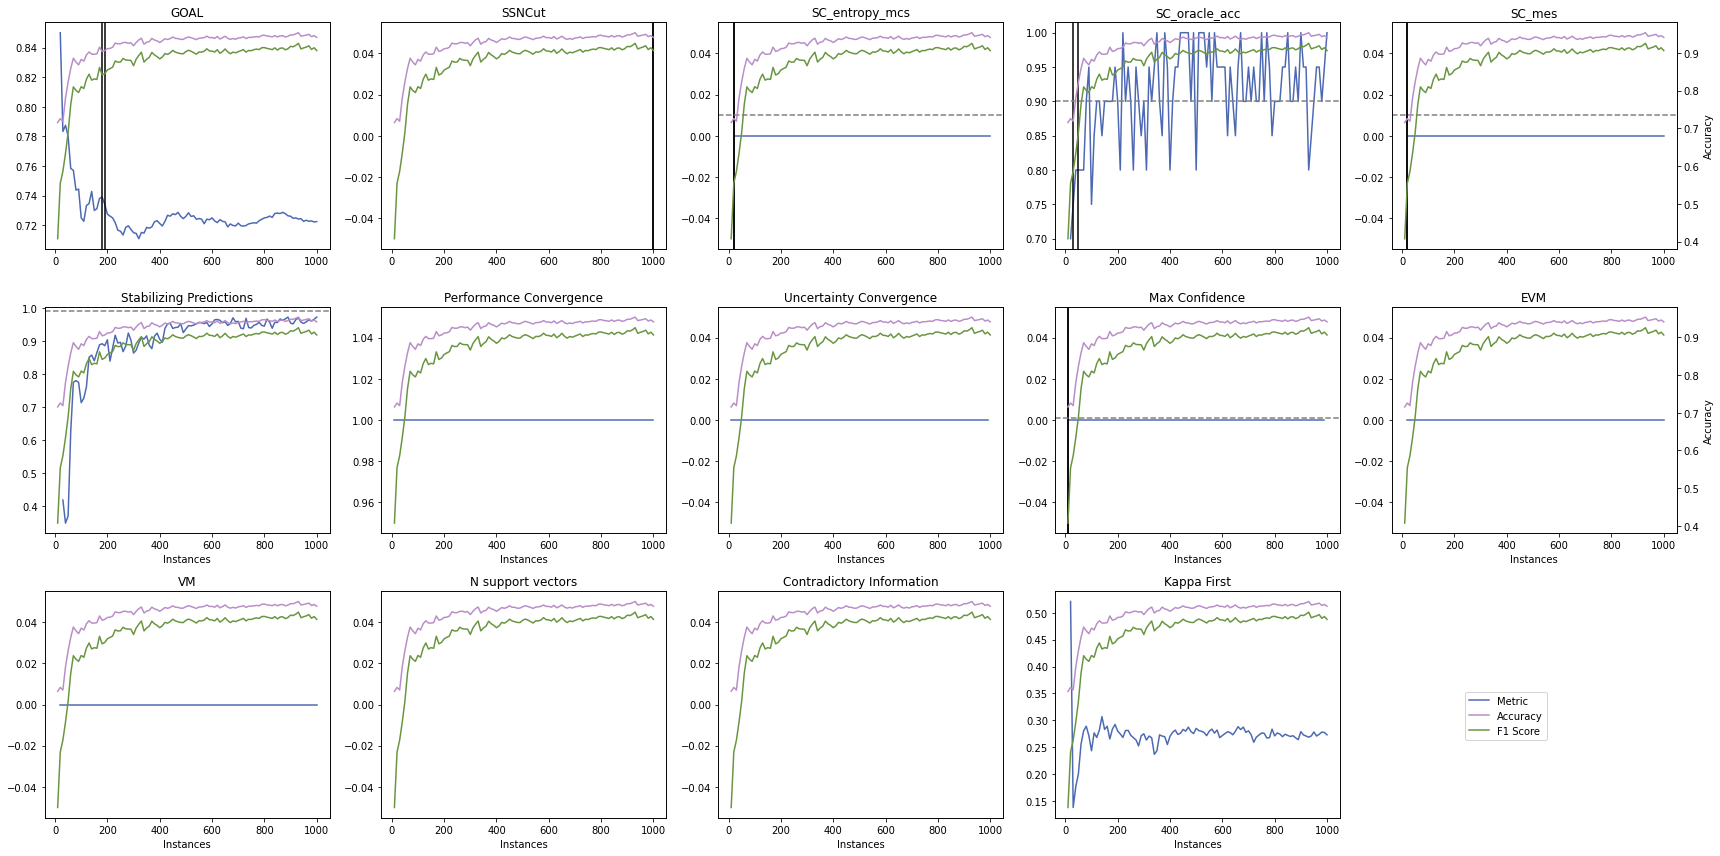

In [211]:
plot_with_metric(results_plots, classifiers)

## Random Forest

In [229]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("spamassassin", wrap(spamassassin, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "random-forest"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-c9330753-7d4d-4d45-927f-679f011b92aa.json']


Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

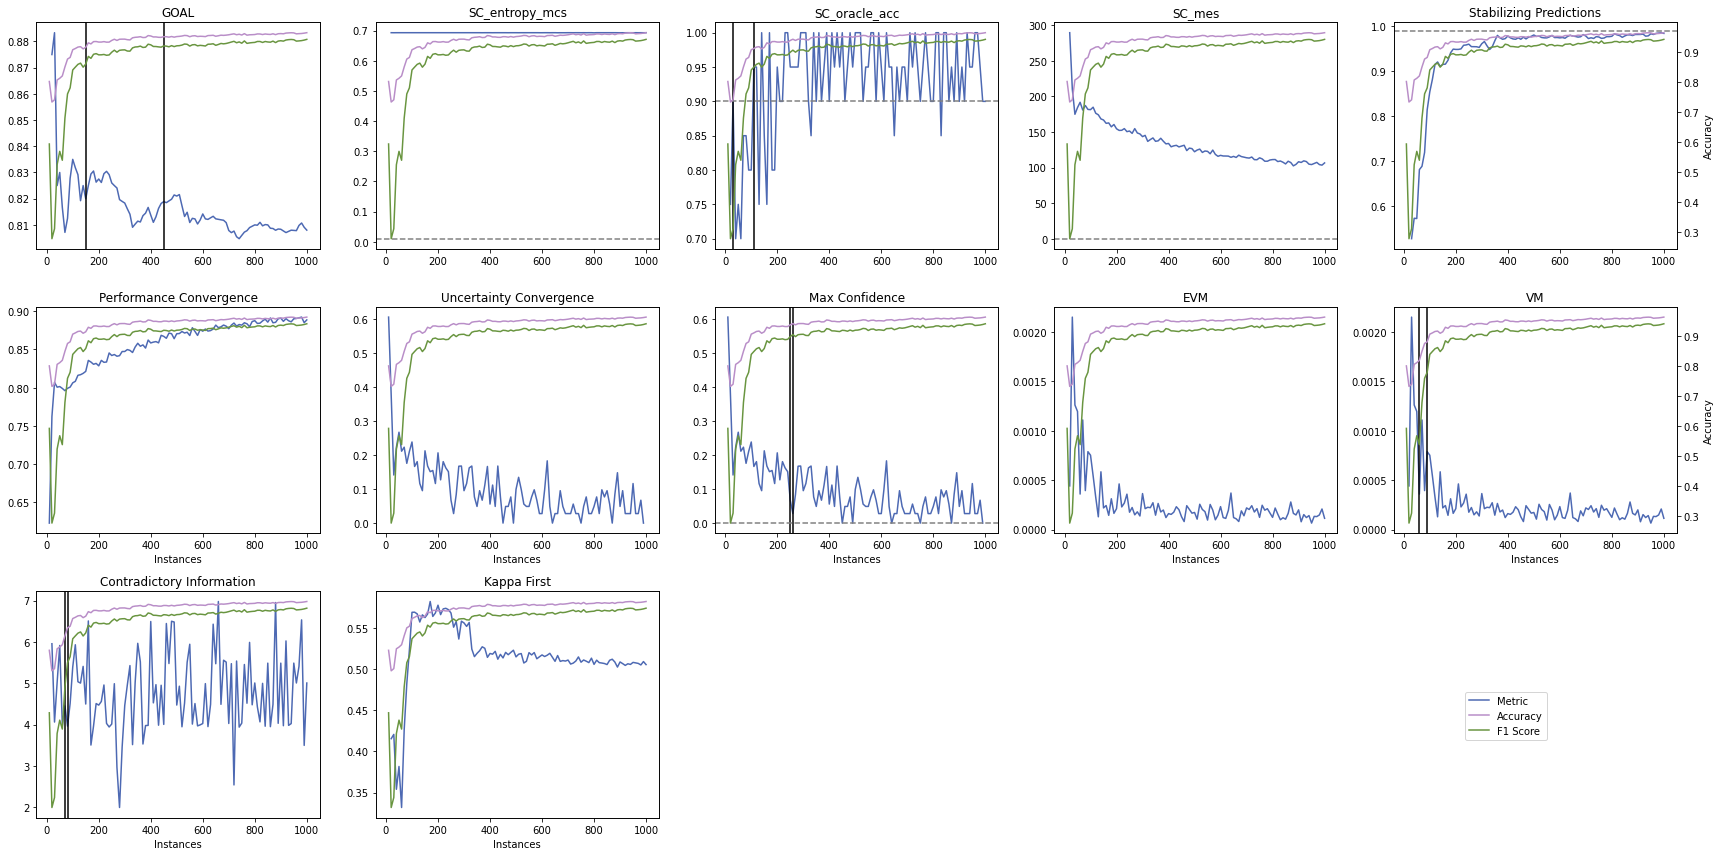

In [230]:
plot_with_metric(results_plots, classifiers)

## Neural Net

In [217]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("avila", wrap(avila, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "neural-network"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-c9330753-7d4d-4d45-927f-679f011b92aa.json']


Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

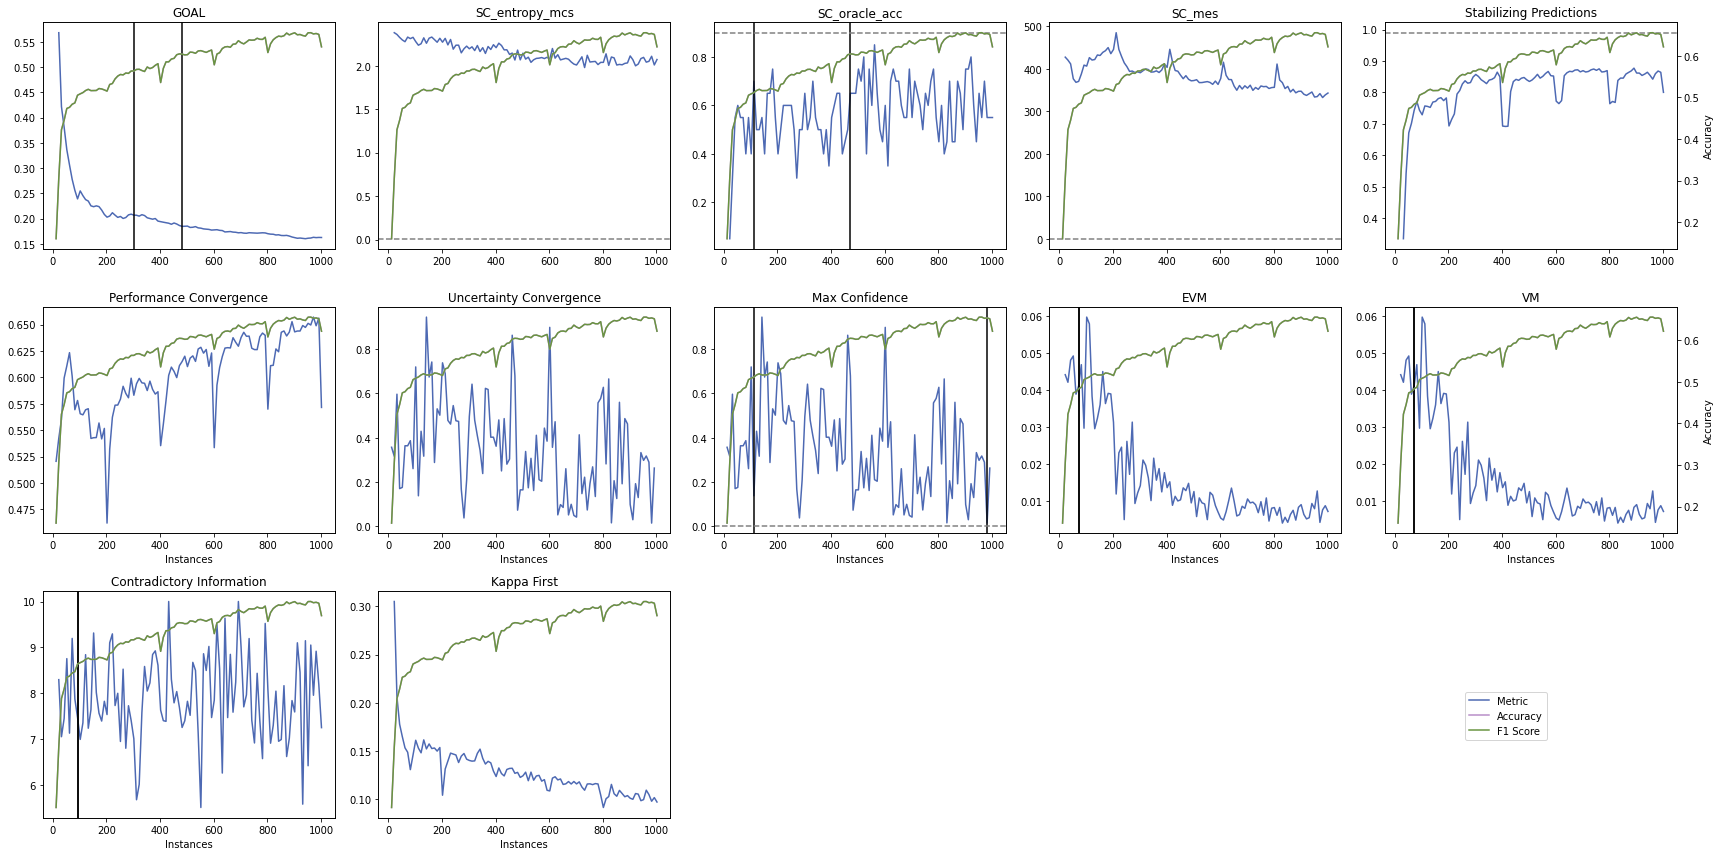

In [228]:
plot_with_metric(results_plots, classifiers)